## Bell Study Model Analysis

This is the preliminary Bell Study analysis NN model using Keras, AutoKeras, KerasTuner. 

> Author : Y.Y. Gary Peng  
> Istitute: National Tsing Hua University, Taiwan and ATLAS experiment, CERN  
> License : MIT  
> Data : August 19, 2023  
> Email : yuan-yen.peng@cern.ch

Version : 1.0


In [1]:
import os
import gc
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from numba import njit
import mplhep as hep
import matplotlib.pyplot as plt
import plot.AtlasPlot as atlas
import glob
import uproot
import ROOT

Welcome to JupyROOT 6.28/04


In [2]:
def get_files_names(path):
    files_name = glob.glob(path)
    return files_name

path = "./truth/*/*.npz"
files_name = get_files_names(path)
print(files_name)

def get_data(path):
    try:
        with np.load(path, allow_pickle=True) as f:
            data_dict = {name: f[name] for name in f.files}
            return pd.DataFrame(data_dict)
    except FileNotFoundError:
        print("File not found!")
        return pd.DataFrame()
    
files = []
files_name.sort()
for f in files_name:
    files.append(get_data(f))
    
# need to check the order of data name.
files_name

# need to follow the order of data name.
(
    CGLMP,
    Higgs,
    LeadLep,
    LepM,
    LepP,
    NuM,
    NuP,
    MET,
    Wm,
    Wp,
    diLep,
    SubLep,
    Xi,
) = files
GEV=1e3

del files_name, files
gc.collect()

['./truth/archive/CGLMP.npz', './truth/archive/WpBoson.npz', './truth/archive/subLeadLepton.npz', './truth/archive/LeptonP.npz', './truth/archive/Higgs.npz', './truth/archive/LeadLepton.npz', './truth/archive/LeptonM.npz', './truth/archive/xi_xyz.npz', './truth/archive/WmBoson.npz', './truth/archive/LmNu.npz', './truth/archive/LpNu.npz', './truth/archive/MET.npz', './truth/archive/diLepton.npz']


451

In [3]:
# Some constants
GEV = 1e3
# RMV_EVT = [638488, 835579, 2168342] # escape some mathmetical errors.
RMV_EVT = [] # escape some mathmetical errors.

In [4]:
# Kinemetic info of leptons.
lep_kin = pd.DataFrame({
    'lep_p_E' : LepP['E'],
    'lep_p_px': LepP['px'],
    'lep_p_py': LepP['py'],
    'lep_p_pz': LepP['pz'],
    'lep_m_E' : LepM['E'],
    'lep_m_px': LepM['px'],
    'lep_m_py': LepM['py'],
    'lep_m_pz': LepM['pz'],
})

# check format l+ -> (E, px, py, pz); then, append l- with the same format of l+.
print(lep_kin.shape)
lep_kin.drop(RMV_EVT, inplace=True)
print(lep_kin.shape)
lep_kin.head(5)

# Kinemetic info of neutirnos.
nu_kin = pd.DataFrame({
    'nu_p_E' : NuP['E'],
    'nu_p_px': NuP['px'],
    'nu_p_py': NuP['py'],
    'nu_p_pz': NuP['pz'],
    'nu_m_E' : NuM['E'],
    'nu_m_px': NuM['px'],
    'nu_m_py': NuM['py'],
    'nu_m_pz': NuM['pz'],
})

# check format nu+ -> (E, px, py, pz); then, append nu- with the same format of l+.
print(nu_kin.shape)
nu_kin.drop(RMV_EVT, inplace=True)
print(nu_kin.shape)
nu_kin.head(5)

(2928862, 8)
(2928862, 8)
(2928862, 8)
(2928862, 8)


,nu_p_E,nu_p_px,nu_p_py,nu_p_pz,nu_m_E,nu_m_px,nu_m_py,nu_m_pz
0,75449.546875,-5933.026855,30212.091797,68881.515625,46680.429688,27464.617188,28449.271484,24807.183594
1,226696.359375,59309.222656,-25300.892578,217332.734375,384335.750000,83522.359375,-10934.743164,374991.218750
2,8372.311523,-7214.337402,-4222.511230,-468.329315,66342.890625,3095.675049,-48527.265625,45132.035156
3,10764.709961,-1976.395264,-5639.073242,-8953.976562,30333.171875,-17860.195312,-11609.113281,21594.980469
4,71970.890625,-19597.880859,-10960.045898,68378.429688,82460.156250,-2266.198486,-15764.699219,80907.453125


In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
print(tf.config.list_physical_devices())
from tensorflow import keras
from tensorflow.keras import layers
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID' # If the line below doesn't work, uncomment this line (make sure to comment the line below); it should help.
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.9.0


1.0 0.0
0.07165805795577462
2928862


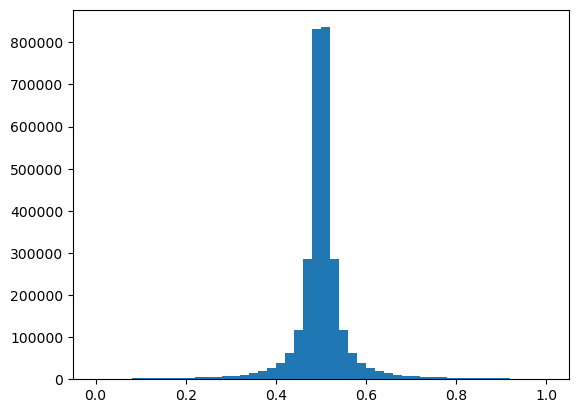

6.977049498779858 -6.978117571636797
0.9999999999999993
2928862


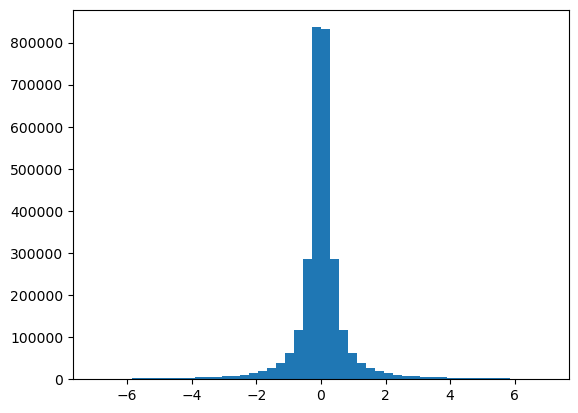

In [6]:
# prepare parameters
from sklearn.preprocessing import StandardScaler

# # Bxy
# BXY_MAX = CGLMP['Bxy'].max(axis=None)
# BXY_MIN = CGLMP['Bxy'].min(axis=None)                     
# Bxy_norm = (CGLMP['Bxy'] - BXY_MIN)/(BXY_MAX - BXY_MIN)

# Higgs mass
# MinMax
H_M_MAX  = Higgs['m'].max(axis=None)
H_M_MIN  = Higgs['m'].min(axis=None)                     
H_M_norm = (Higgs['m'] - H_M_MIN)/(H_M_MAX - H_M_MIN)
# H_M_norm = Higgs['m']
print(H_M_norm.max(), H_M_norm.min())
print(H_M_norm.std())
print(len(H_M_norm))
plt.hist(H_M_norm, bins=50)
plt.show()

# Std
SCALAR = StandardScaler()
H_M_std = SCALAR.fit_transform([[x] for x in Higgs['m']]).flatten() # zero mean and unit variance
print(H_M_std.max(), H_M_std.min())
print(H_M_std.std())
print(len(H_M_std))
plt.hist(H_M_std, bins=50)
plt.show()

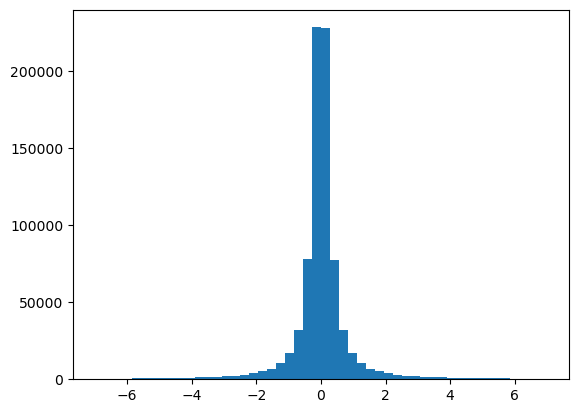

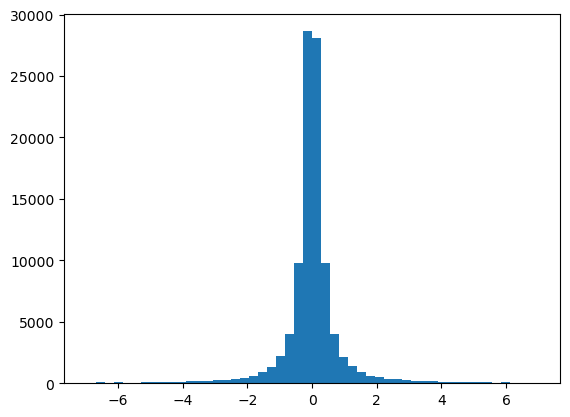

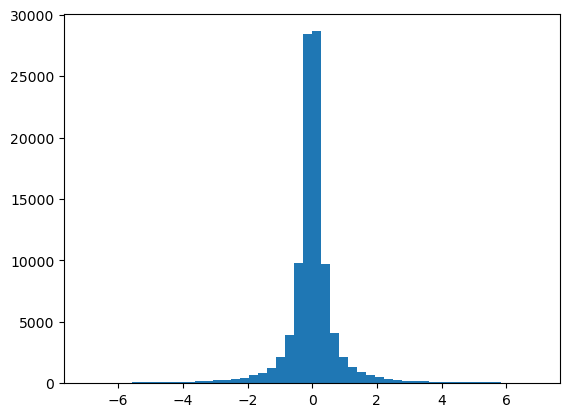

With the same shapes...

Training data shape: (800000, 4, 4)
Testing data shape: (100000, 4, 4)
Validation data shape: (100000, 4, 4)
None


In [7]:
from sklearn.model_selection import train_test_split

lepton_features   = ['lep_p_E','lep_p_px','lep_p_py','lep_p_pz',
                     'lep_m_E','lep_m_px','lep_m_py','lep_m_pz']
neutrino_features = ['nu_p_E','nu_p_px','nu_p_py','nu_p_pz',
                     'nu_m_E','nu_m_px','nu_m_py','nu_m_pz']

def reshape_features(inputs, features):
    outputs = np.stack([inputs[features[0:4]],
                        inputs[features[4:8]]], axis=1)
    return outputs

indices = np.arange(int(1e6)) # sampling size
train_indices, temp_indices = train_test_split(indices, train_size=0.8, test_size=0.2, random_state=42)
valid_indices, test_indices = train_test_split(temp_indices, train_size=0.5, test_size=0.5, random_state=42)

lep_train = reshape_features(lep_kin.iloc[train_indices], lepton_features)
lep_valid = reshape_features(lep_kin.iloc[valid_indices], lepton_features)
lep_test  = reshape_features(lep_kin.iloc[test_indices],  lepton_features)

nu_train = reshape_features(nu_kin.iloc[train_indices], neutrino_features)
nu_valid = reshape_features(nu_kin.iloc[valid_indices], neutrino_features)
nu_test  = reshape_features(nu_kin.iloc[test_indices],  neutrino_features)

H_m_train = H_M_std[train_indices]
H_m_valid = H_M_std[valid_indices]
H_m_test  = H_M_std[test_indices]
plt.hist(H_m_train, bins=50)
plt.show()
plt.hist(H_m_valid, bins=50)
plt.show()
plt.hist(H_m_test, bins=50)
plt.show()

def stack_parts(input1, input2):
    outputs = np.concatenate([input1, input2], axis=1)
    return outputs

if (lep_train.shape == nu_train.shape and 
    lep_test.shape  == nu_test.shape and 
    lep_valid.shape == nu_valid.shape):
    print('With the same shapes...\n')
    # print(f'Training data shape: {lep_train.shape}\nTesting data shape: {lep_test.shape}\nValidation data shape: {lep_valid.shape}')
    train = stack_parts(lep_train, nu_train)
    valid = stack_parts(lep_valid, nu_valid)
    test  = stack_parts(lep_test , nu_test)
    FEA_MAX = np.max([train.max(), valid.max(), test.max()])
    FEA_MIN = np.min([train.min(), valid.min(), test.min()])
    train = (train - FEA_MIN)/(FEA_MAX - FEA_MIN)
#     train = np.expand_dims(train, axis=-1)
    valid = (valid - FEA_MIN)/(FEA_MAX - FEA_MIN)
#     valid = np.expand_dims(valid, axis=-1)
    test  = (test - FEA_MIN) /(FEA_MAX - FEA_MIN)
#     test = np.expand_dims(test, axis=-1)
    print(print(f'Training data shape: {train.shape}\nTesting data shape: {test.shape}\nValidation data shape: {valid.shape}'))
    
    del (indices, train_indices, temp_indices, valid_indices, test_indices,
        lep_train, lep_valid, lep_test,
        nu_train, nu_valid, nu_test)
    gc.collect()
    
else:
    print('The shape of leptons are NOT the same with neutrinos shape...\n')
    print(f'Training data shape: {lep_train.shape}, {nu_train.shape}\nTesting data shape: {lep_test.shape}, {nu_test.shape}\nValidation data shape: {lep_valid.shape}, {nu_valid.shape}')

In [8]:
print(f'Train: mean->{train.mean():.3f}, std->{train.std():.3f}, min->{train.min():.3f}, max->{train.max():.3f}')
print(f'Valid: mean->{valid.mean():.3f}, std->{valid.std():.3f}, min->{valid.min():.3f}, max->{valid.max():.3f}')
print(f'Test : mean->{test.mean():.3f}, std->{test.std():.3f}, min->{test.min():.3f}, max->{test.max():.3f}\n')

print(f'Feature_train : mean->{H_m_train.mean():.3f}, std->{H_m_train.std():.3f}, min->{H_m_train.min():.3f}, max->{H_m_train.max():.3f}')
print(f'Feature_valid : mean->{H_m_valid.mean():.3f}, std->{H_m_valid.std():.3f}, min->{H_m_valid.min():.3f}, max->{H_m_valid.max():.3f}')
print(f'Feature_test  : mean->{H_m_test.mean():.3f}, std->{H_m_test.std():.3f}, min->{H_m_test.min():.3f}, max->{H_m_test.max():.3f}')

Train: mean->0.479, std->0.016, min->0.000, max->1.000
Valid: mean->0.479, std->0.016, min->0.068, max->0.884
Test : mean->0.479, std->0.016, min->0.037, max->0.914

Feature_train : mean->-0.001, std->1.002, min->-6.976, max->6.976
Feature_valid : mean->0.001, std->1.006, min->-6.972, max->6.973
Feature_test  : mean->0.002, std->0.994, min->-6.977, max->6.971


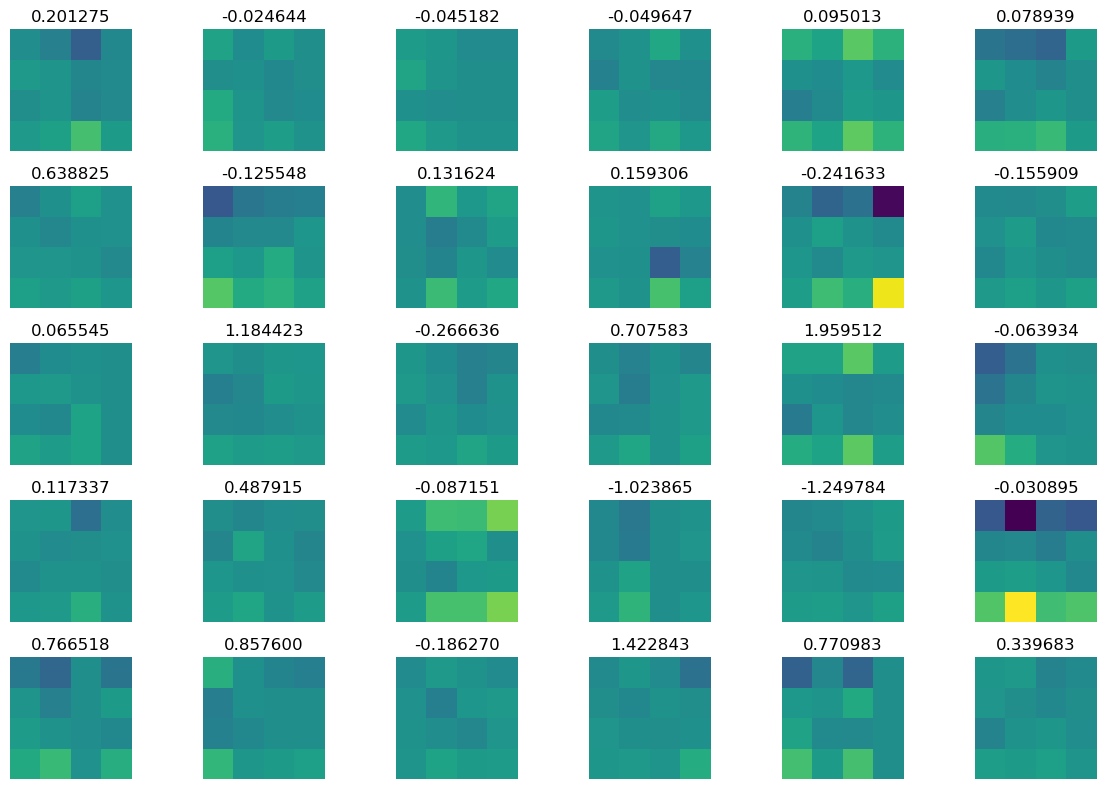

In [23]:
# Create random data for 50 figures (4x4 matrices)
num_figures = 30
figure_size = 4

# Calculate the grid dimensions (rows x columns)
num_rows = 5
num_cols = 6

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the figures and plot them on subplots
for i, ax in enumerate(axes):
    ax.imshow(train[i].T, cmap='viridis', origin='lower', vmin=train[0:num_figures+1].min(), vmax=train[0:num_figures+1].max())
    ax.set_title(f'{H_m_train[i]:2f}')
    ax.axis('off')  # Turn off axis labels

# Adjust layout and show the plot
plt.tight_layout()